In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
from pickle import dump
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('neuron')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
import random
sys.path.append('../')
from Linearity import Neuron

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def simpleaxis(axes, every=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

### Histogram method of finding MI

In [178]:
def getNumBins(X, rule="S"):

    if rule == "FD":
        # Freedman‐Diaconis Rule!
        minMax = max(X) - min(X)
        Qx = sp.stats.iqr(X)
        N_cubrt = np.cbrt(len(X))
        print (minMax, Qx, N_cubrt, minMax/(2.* Qx * N_cubrt))
        return int(np.ceil(minMax/(2.* Qx * N_cubrt)))
    elif rule == "S":
        # Sturges’ Rule!
        return int(np.ceil(1. + np.log2(len(X))))

def calc_MI(X,Y,bins):

    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_XY = np.histogram2d(X,Y, bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    normalized_MI = MI    # In bits, or normalize: /(np.sqrt(H_X*H_Y))
    return normalized_MI

def calc_TI(X,Y,Z,bins):
    ''' Total Information about Z from X and Y, or I(Z; X,Y)'''

    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_Z = np.histogram(Z, bins=bins)[0]

    c_XY = np.histogram2d(X,Y, bins=bins)[0]
    c_XYZ = np.histogramdd((X,Y,Z), bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_Z = shan_entropy(c_Z)

    H_XY = shan_entropy(c_XY)
    H_XYZ = shan_entropy(c_XYZ)

    TI = H_Z + H_XY - H_XYZ
    normalized_TI = TI  # In bits, or normalize: /(np.sqrt(H_X*H_Y))
    return normalized_TI

def gain_inf(X,Y,Z, bins):
    ''' Calculates the gain in information with timing. I(X;Y|Z)'''
    c_X = np.histogram(X, bins=bins)[0]
    c_Y = np.histogram(Y, bins=bins)[0]
    c_Z = np.histogram(Z, bins=bins)[0]

    c_XY = np.histogram2d(X,Y, bins=bins)[0]
    c_XZ = np.histogram2d(X,Z, bins=bins)[0]
    c_YZ = np.histogram2d(Y,Z, bins=bins)[0]
    c_XYZ = np.histogramdd((X,Y,Z), bins=bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_Z = shan_entropy(c_Z)

    H_XY = shan_entropy(c_XY)
    H_XZ = shan_entropy(c_XZ)
    H_YZ = shan_entropy(c_YZ)
    H_XYZ = shan_entropy(c_XYZ)

    GI = H_XZ + H_YZ - H_XYZ - H_Z
    return GI
        
def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))
    return H

def shuffle_test(X,Y,Z=[], bins=0, n=500, measure='mi'):
        
    if measure == 'mi':
        true_MI = calc_MI(X,Y, bins)

        shuffled_mi = np.array([calc_MI(np.random.permutation(X),Y, bins) for jj in range(n)])
        conf = len(np.where(shuffled_mi>true_MI)[0])/float(len(shuffled_mi))
#         print("Mean shuffled MI is {}".format(np.mean(shuffled_mi)))
    elif measure == 'cmi':
        true_CMI = gain_inf(X,Y,Z, bins)

        shuffled_cmi = np.array([gain_inf(np.random.permutation(X),Y,Z, bins) for jj in range(n)])
        conf = len(np.where(shuffled_cmi>true_CMI)[0])/float(len(shuffled_cmi))
#         print("Mean shuffled CMI is {}".format(np.mean(shuffled_cmi)))
    elif measure == 'ti':
        true_TI = calc_TI(X,Y,Z, bins)
        shuffled_ti = np.array([calc_TI(X,Y, np.random.permutation(Z), bins) for jj in range(n)])
        conf = len(np.where(shuffled_ti>true_TI)[0])/float(len(shuffled_ti))
#         print("Mean shuffled TI is {}".format(np.mean(shuffled_ti)))
    return conf

In [199]:
import sys
sys.path.append('../../NPEET/')
import entropy_estimators as ee

In [200]:
def calc_MI(X,Y,bins=0,k = 3):

    X = ee.vectorize(X)
    Y = ee.vectorize(Y)
    return ee.mi(X,Y,k=k)

def calc_TI(X,Y,Z,bins=0,k = 3):
    ''' Total Information about Z from X and Y, or I(Z; X,Y)'''

    X = ee.vectorize(X)
    Y = ee.vectorize(Y)
    Z = ee.vectorize(Z)
    
    TI = ee.cmi(Z,X,Y,k=k) + ee.mi(Z,Y,k=k)

    return TI

def gain_inf(X,Y,Z, bins=0,k = 3):
    ''' Calculates the gain in information with timing. I(X;Y|Z)'''

    X = ee.vectorize(X)
    Y = ee.vectorize(Y)
    Z = ee.vectorize(Z)
    
    CMI = ee.cmi(X,Y,Z,k=k)
    return CMI

def shuffle_test(X,Y,Z=[], n=500, measure='mi'):
        
    if measure == 'mi':
        true_MI = calc_MI(X,Y)

        shuffled_mi = np.array([calc_MI(np.random.permutation(X),Y) for jj in range(n)])
        conf = len(np.where(shuffled_mi>true_MI)[0])/float(len(shuffled_mi))
#         print("Mean shuffled MI is {}".format(np.mean(shuffled_mi)))
    elif measure == 'cmi':
        true_CMI = gain_inf(X,Y,Z)

        shuffled_cmi = np.array([gain_inf(np.random.permutation(X),Y,Z) for jj in range(n)])
        conf = len(np.where(shuffled_cmi>true_CMI)[0])/float(len(shuffled_cmi))
#         print("Mean shuffled CMI is {}".format(np.mean(shuffled_cmi)))
    elif measure == 'ti':
        true_TI = calc_TI(X,Y,Z)
        shuffled_ti = np.array([calc_TI(X,Y, np.random.permutation(Z)) for jj in range(n)])
        conf = len(np.where(shuffled_ti>true_TI)[0])/float(len(shuffled_ti))
#         print("Mean shuffled TI is {}".format(np.mean(shuffled_ti)))
    return conf

In [115]:
X = np.array(range(100))

In [387]:
np.where(np.array([1,2,3])>1)[0]

array([1, 2])

In [6]:
def getPars_trialwise(neuron, expType="Control", feature=0, notSqrs = [1]):
    ''' Returns Expected, Observed, Time, Squares for the experiment'''
    exp = neuron.experiment[expType]
    expected = []
    observed = []
    time = []
    sqrArr = []
    trace = []
    for sqr in exp:
        if sqr not in notSqrs:
            for coord in exp[sqr].coordwise:
                for trial in exp[sqr].coordwise[coord].trials:
                    if all([value == 0 for value in trial.flags.values()]) and not np.isnan(exp[sqr].coordwise[coord].expected_feature[feature]):
                        expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                        observed.append(trial.feature[feature])
                        time.append(np.argmax(trial.interestWindow)/20.)
                        sqrArr.append(sqr)
                        trace.append(trial.interestWindow)
    return expected, observed, time, sqrArr, trace

In [7]:
def getPars(neuron, expType="Control", feature=0, notSqrs = [1]):
    ''' Returns Expected, Observed, Time, Squares for the experiment'''
    exp = neuron.experiment[expType]
    expected = []
    observed = []
    time = []
    sqrArr = []
    avgTrace = []
    for sqr in exp:
        if sqr not in notSqrs:
            for coord in exp[sqr].coordwise:
                if not np.isnan(exp[sqr].coordwise[coord].expected_feature[feature]):
                    obs,t = [], []
                    trace = []
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            obs.append(trial.feature[feature])
                            t.append(np.argmax(trial.interestWindow)/20.)
                            trace.append(trial.interestWindow)
                    if not (all(np.isnan(obs)) or all(np.isnan(t))):
                        observed.append(np.nanmean(obs))
                        expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                        time.append(np.nanmean(t))
                        averagedTrace = np.mean(trace,axis=0)
                        avgTrace.append(averagedTrace)
                        sqrArr.append(sqr)
    return expected, observed, time, sqrArr,avgTrace

In [9]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/normalization_files.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [13]:
feature = 0
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

In [10]:
neuron = Neuron.load('/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/161013/c1/plots/c1.pkl')

In [14]:
neuron = neurons['170303_c1']

In [15]:
feature = 0 # Area under the curve
trace = []
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        expected = []
        observed = []
        time = []
        sqrArr = []
        for sqr in exp:
            if sqr > 1:
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                            observed.append(trial.feature[feature])
                            time.append(np.argmax(trial.interestWindow)/20.)
                            trace.append(trial.interestWindow)
                            sqrArr.append(sqr)

In [16]:
observed = np.array(observed)
time = np.array(time)
expected = np.array(expected)
trace = np.array(trace)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python2.7

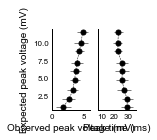

In [17]:
bins = np.linspace(0,12,10)
digitized = np.digitize(expected, bins)
exp_mean = [expected[digitized == i].mean() for i in range(len(bins))]
obs_mean = [observed[digitized == i].mean() for i in range(len(bins))]
obs_std = [observed[digitized == i].std() for i in range(len(bins))]
time_mean = [time[digitized == i].mean() for i in range(len(bins))]
time_std = [time[digitized == i].std() for i in range(len(bins))]

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(obs_mean, exp_mean,'.')
ax[0].errorbar(obs_mean, exp_mean, xerr = obs_std,linestyle='--') #s= 10)
ax[1].plot(time_mean, exp_mean,'.')
ax[1].errorbar(time_mean, exp_mean, xerr = time_std,linestyle='--')# s= 10)

#ax[0].scatter(observed, expected, s= 10)
#ax[1].scatter(time, expected, s= 10)
ax[0].set_xlim(0,6)
ax[1].set_xlim(7,36)
ax[0].set_xlabel('Observed peak voltage (mV)')
ax[1].set_xlabel('Peak time (ms)')
ax[0].set_ylabel('Expected peak voltage (mV)')
simpleaxis(ax)
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
#dump(fig,file('figures/fig7/7a.pkl','wb'))
plt.show()

In [15]:
print(max(expected))

17.214748093230323


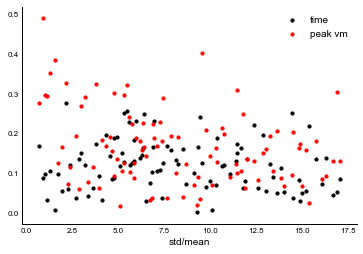

In [16]:
feature = 0 # Area under the curve
neuron = neurons['170303_c1']
trace = []
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        std_time = []
        std_observed = [] 
        expected = []
        for sqr in exp:
            if sqr > 1:
                for coord in exp[sqr].coordwise:
                    time_trial, observed_trial = [], []
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            time_trial.append(np.argmax(trial.interestWindow)/20.)
                            observed_trial.append(np.max(trial.interestWindow))
                    if len(observed_trial) == 3:
                        expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                        std_time.append( np.std(time_trial)/np.mean(time_trial))
                        std_observed.append( np.std(observed_trial)/np.mean(observed_trial))

fig, ax = plt.subplots()
ax.scatter(expected, std_time, color='k', label='time', s=10)
ax.scatter(expected, std_observed, color='r', label='peak vm', s=10)
ax.set_xlabel("Expected")
ax.set_xlabel("std/mean")
simpleaxis(ax)
plt.legend()
plt.show()

## Showing raw traces for timing information (Gabazine vs Control)

### Loading GABAzine containing files

In [9]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files_with_GABAzine.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [10]:
feature = 0
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

## Trying out the slope idea

c1 161117


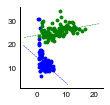

c2 170222


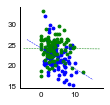

c1 161228


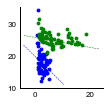

c3 161027


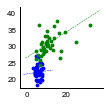

c1 160920


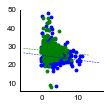

c1 161013


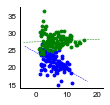

c5 160927


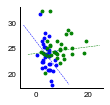

c1 170303


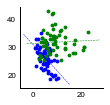

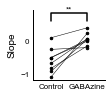

In [353]:
feature = 0
slope_c , slope_g = [], []
for key in neurons:
    neuron = neurons[key]
    trace, g_trace, expected, g_expected, g_observed, observed, time, g_time = [], [], [], [], [], [], [], []
    #notSqrs = [1]
    if "GABAzine" in neuron.experiment:

        g_expected, g_observed, g_time, g_sqrArr, g_trace = getPars(neuron, "GABAzine", notSqrs = notSqrs, feature=feature)
        expected, observed, time, sqrArr, trace = getPars(neuron, "Control", notSqrs = notSqrs, feature=feature)
        
        g_time = [np.argmax(averagedTrace)/20. for averagedTrace in g_trace]
        g_observed = [np.max(averagedTrace) for averagedTrace in g_trace]

        time = [np.argmax(averagedTrace)/20. for averagedTrace in trace]
        observed = [np.max(averagedTrace) for averagedTrace in trace]

        expected = np.array(expected)
        trace = np.array(trace)
        g_expected = np.array(g_expected)
        g_trace = np.array(g_trace)
        observed = np.array(observed)
        time = np.array(time)
        g_observed = np.array(g_observed)
        g_time = np.array(g_time)

        indices =list(set(np.where(time<50)[0]).intersection(np.where(g_time<50)[0]).intersection(np.where(time>5)[0]).intersection(np.where(g_time>5)[0]))

        expected = expected[indices]
        time = time[indices]
        g_expected = g_expected[indices]
        g_time = g_time[indices]

        if(( ss.iqr(g_expected))>=1.):
            print (neuron.index, neuron.date)
            fig, ax = plt.subplots()
            slope, intercept, lowconf, highconf = ss.mstats.theilslopes(x=expected, y=time)
            slope_c.append(slope)
            ax.scatter(expected, time, c='blue', s=8)
            xaxis = np.linspace(min(expected)-5, max(expected)+5,30)
            ax.plot(xaxis , slope*xaxis  + intercept, 'b--')

            slope, intercept, lowconf, highconf = ss.mstats.theilslopes(x=g_expected, y=g_time)
            slope_g.append(slope)
            ax.scatter(g_expected, g_time, c='g', s=8)
            xaxis = np.linspace(min(g_expected)-5, max(g_expected)+5,30)
            ax.plot(xaxis, slope*xaxis + intercept, 'g--')
            simpleaxis(ax)
            fig.set_figwidth(1.5)
            fig.set_figheight(1.5)
            plt.show()
            
fig, ax = plt.subplots()
for c,g in zip(slope_c, slope_g):
    ax.plot([1,3], [c,g], '.-', markersize=5)

ax.set_xlim((0,4))
ax.set_xticks([1,3])
ax.set_xticklabels(['Control', 'GABAzine'])
ax.set_ylabel("Slope")

y, h, col = np.max([np.max(slope_c),np.max(slope_g)])+ 0.2 , 0.25, 'k'
plt.plot([1,1, 3, 3], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((1+3)*.5, y+h, "**", ha='center', va='bottom', color=col)

simpleaxis(ax)
fig.set_figwidth(1.3)
fig.set_figheight(1.3)
plt.savefig('figures/fig7/Slope_control_gabazine.svg')
plt.show()

In [352]:
print(ss.ranksums(slope_c, slope_g))

RanksumsResult(statistic=-2.730546163854619, pvalue=0.006322947695810933)


In [290]:
feature = 0 # Area under the curve
neuron = neurons['170303_c1']

In [291]:
trace, g_trace, expected, g_expected, g_observed, observed, time, g_time = [], [], [], [], [], [], [], []
notSqrs = [1]
g_expected, g_observed, g_time, g_sqrArr, g_trace = getPars(neuron, "GABAzine", notSqrs = notSqrs, feature=feature)
expected, observed, time, sqrArr, trace = getPars(neuron, "Control", notSqrs = notSqrs, feature=feature)

g_time = [np.argmax(averagedTrace)/20. for averagedTrace in g_trace]
g_observed = [np.max(averagedTrace) for averagedTrace in g_trace]

time = [np.argmax(averagedTrace)/20. for averagedTrace in trace]
observed = [np.max(averagedTrace) for averagedTrace in trace]

In [292]:
expected = np.array(expected)
trace = np.array(trace)
g_expected = np.array(g_expected)
g_trace = np.array(g_trace)
observed = np.array(observed)
time = np.array(time)
g_observed = np.array(g_observed)
g_time = np.array(g_time)

In [326]:
numBins=20
bins = np.linspace(0,max(expected),numBins)
digitized = np.digitize(expected, bins)
trace_mean = [trace[digitized == i].mean(axis=0) for i in range(len(bins)) if len(trace[digitized == i])]

bins = np.linspace(0,max(g_expected),numBins)
g_digitized = np.digitize(g_expected, bins)
g_trace_mean = [g_trace[g_digitized == i].mean(axis=0) for i in range(len(bins)) if len(g_trace[g_digitized == i])]
g_trace_time = [g_trace[g_digitized == i].mean(axis=0) for i in range(len(bins)) if len(g_trace[g_digitized == i])]

-0.28476075626021063 11.07227988739361
0.5571473325962897 28.2275142472747


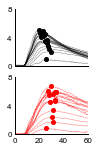

In [332]:
c_mean_time, c_mean, g_mean_time, g_mean = [], [], [], []
alpha=0.5
fig, ax = plt.subplots(2,1,sharex=True, sharey=True)
for i in range(len(trace_mean)):
    if len(trace_mean[i]):
        ax[0].plot(np.linspace(0,100,len(trace_mean[i])), trace_mean[i], alpha=alpha)
        ax[0].plot(np.argmax(trace_mean[i])/20.,np.max(trace_mean[i]),'.',markersize=8)
        c_mean_time.append(np.argmax(trace_mean[i])/20.)
        c_mean.append(np.max(trace_mean[i]))
slope, intercept, lowconf, highconf = ss.mstats.theilslopes(x=c_mean_time, y=c_mean)
meanTimeRange = np.linspace(0.8*np.min(c_mean_time), 1.2*np.max(c_mean_time),30)
# ax[0].plot(meanTimeRange, slope*meanTimeRange + intercept,'--',linewidth=1)
print (slope, intercept)
for i in range(len(g_trace_mean)):
    if len(g_trace_mean[i]):
        ax[1].plot(np.linspace(0,100,len(g_trace_mean[i])), g_trace_mean[i],'r', alpha=alpha)
        ax[1].plot(np.argmax(g_trace_mean[i])/20.,np.max(g_trace_mean[i]),'r.',markersize=8)
        g_mean_time.append(np.argmax(g_trace_mean[i])/20.)
        g_mean.append(np.max(g_trace_mean[i]))

# slope, intercept, lowconf, highconf, k = ss.linregress(x=g_mean_time, y=g_mean)
slope, intercept, lowconf, highconf = ss.mstats.theilslopes(x=g_mean, y=g_mean_time)
meanTimeRange = np.linspace(0.8*np.min(g_mean_time), 1.2*np.max(g_mean_time),30)

ax[1].plot(meanTimeRange, meanTimeRange*slope + intercept,'r--',linewidth=1)
print (slope, intercept)
# c_mean/=len(trace_mean)
# g_mean/=len(g_trace_mean)

# ax[0].vlines(x=c_mean ,ymin=0., ymax=1.1*np.max(trace_mean),linestyle='--')
# ax[1].vlines(x=g_mean ,ymin=0., ymax=1.1*np.max(g_trace_mean),color='r',linestyle='--')

# ax[1].set_xlabel('Time (ms)')
# ax[1].set_ylabel('Amplitude (mV)')

ax[0].set_xlim(0,60)
ax[0].set_ylim(ymin=0., ymax=8.)
ax[1].set_ylim(ymin=0., ymax=8.)
ax[0].set_yticks([0,4,8])
ax[1].set_yticks([0,4,8])
simpleaxis(ax)
fig.set_figheight(2.3)
fig.set_figwidth(1.3)
dump(fig,file('figures/fig7/7c.pkl','wb'))
plt.show()

In [297]:
print(slope)

0.21618280225246955


In [47]:
c_mean_time

[28.1, 27.15, 26.2, 21.25, 23.6, 21.3, 19.75]

1.7567434848982941 2.1672088688960374


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.


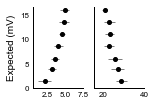

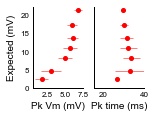

In [48]:
exp_mean = [expected[digitized == i].mean() for i in range(len(bins)) ]
obs_mean = [observed[digitized == i].mean() for i in range(len(bins))]
obs_std = [observed[digitized == i].std() for i in range(len(bins))]
time_mean = [time[digitized == i].mean() for i in range(len(bins))]
time_std = [time[digitized == i].std() for i in range(len(bins))]

g_exp_mean = [g_expected[g_digitized == i].mean() for i in range(len(bins)) ]
g_obs_mean = [g_observed[g_digitized == i].mean() for i in range(len(bins))]
g_obs_std = [g_observed[g_digitized == i].std() for i in range(len(bins))]
g_time_mean = [g_time[g_digitized == i].mean() for i in range(len(bins))]
g_time_std = [g_time[g_digitized == i].std() for i in range(len(bins))]

print(np.nanmin(g_obs_mean), np.nanmin(obs_mean))
omin = 0.3*np.nanmin((np.nanmin(g_obs_mean), np.nanmin(obs_mean)))
omax = 1.1*np.nanmax((np.nanmax(g_obs_mean), np.nanmax(obs_mean)))

tmin = 0.8*np.nanmin((np.nanmin(g_time_mean), np.nanmin(time_mean)))
tmax = 1.2*np.nanmax((np.nanmax(g_time_mean), np.nanmax(time_mean)))

tmin=15.
tmax=40.
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(obs_mean, exp_mean,'.',markersize=8)
ax[0].errorbar(obs_mean, exp_mean, xerr = obs_std, linestyle='') #s= 10)
ax[1].plot(time_mean, exp_mean,'.',markersize=8)
ax[1].errorbar(time_mean, exp_mean, xerr = time_std, linestyle='')# s= 10)
# ax[0].set_xlabel('Pk Vm (mV)')
# ax[1].set_xlabel('Pk time (ms)')
ax[0].set_ylabel('Expected (mV)')
ax[0].set_xlim(omin, omax)
ax[1].set_xlim(tmin,tmax)
ax[0].set_ylim(ymin=0.)
simpleaxis(ax)
fig.set_figwidth(2.0)
fig.set_figheight(1.5)
dump(fig,file('figures/fig7/7a.pkl','wb'))
plt.show()

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(g_obs_mean, g_exp_mean,'r.',markersize=8)
ax[0].errorbar(g_obs_mean, g_exp_mean, xerr = g_obs_std, color='r', linestyle='') #s= 10)
ax[1].plot(g_time_mean, g_exp_mean,'r.',markersize=8)
ax[1].errorbar(g_time_mean, g_exp_mean, xerr = g_time_std, color='r', linestyle='')# s= 10)


ax[0].set_xlabel('Pk Vm (mV)')
ax[1].set_xlabel('Pk time (ms)')
ax[0].set_ylabel('Expected (mV)')
ax[0].set_xlim(omin, omax)
ax[1].set_xlim(tmin,tmax)
ax[0].set_ylim(ymin=0.)
simpleaxis(ax)
fig.set_figwidth(2.0)
fig.set_figheight(1.5)
dump(fig,file('figures/fig7/7b.pkl','wb'))
plt.show()

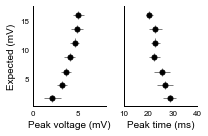

In [49]:
expected, observed, time = np.array(expected), np.array(observed), np.array(time)
bins = np.linspace(0, max(expected), 8)
digitized = np.digitize(expected, bins)
ex_means = [expected[digitized == i].mean() for i in range(1, len(bins))]
ob_means = [observed[digitized == i].mean() for i in range(1, len(bins))]
t_means = [time[digitized == i].mean() for i in range(1, len(bins))]

ex_std = [expected[digitized == i].std() for i in range(1, len(bins))]
ob_std = [observed[digitized == i].std() for i in range(1, len(bins))]
t_std = [time[digitized == i].std() for i in range(1, len(bins))]

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].errorbar(ob_means, ex_means, xerr=ob_std, yerr=ex_std, c='k', fmt='.')
ax[1].errorbar(t_means, ex_means, xerr=t_std, yerr=ex_std, c='k', fmt='.')

ax[0].set_xlim(0,8)
ax[1].set_xlim(10,40)
ax[0].set_xlabel('Peak voltage (mV)')
ax[1].set_xlabel('Peak time (ms)')
ax[0].set_ylabel('Expected (mV)')
simpleaxis(ax)
fig.set_figheight(2)
fig.set_figwidth(3)
fig.tight_layout()
dump(fig,file('figures/fig7/7a.pkl','wb'))
plt.show()

# ax[0].scatter(observed, expected, s= 10)
# ax[1].scatter(time, expected, s= 10)
# ax[0].set_xlim(0,10)
# ax[1].set_xlim(0,50)
# ax[0].set_xlabel('Observed peak voltage (mV)')
# ax[1].set_xlabel('Peak time (ms)')
# ax[0].set_ylabel('Expected peak voltage (mV)')
# simpleaxis(ax)
# dump(fig,file('figures/fig7/7a.pkl','wb'))
# plt.show()

In [27]:
# feature = 0 # Area under the curve
# neuron = neurons['170303_c1']
# trace = []
# fig, ax = plt.subplots(1,2)
# for expType, exp in neuron:
#     ## Control case
#     if(expType == "Control"):
#         std_time = []
#         std_observed = [] 
#         expected = []
#         for sqr in exp:
#             if sqr > 1:
#                 for coord in exp[sqr].coordwise:
#                     time_trial, observed_trial = [], []
#                     for trial in exp[sqr].coordwise[coord].trials:
#                         if all([value == 0 for value in trial.flags.values()]):
#                             time_trial.append(np.argmax(trial.interestWindow)/20.)
#                             observed_trial.append(np.max(trial.interestWindow))
#                     if len(observed_trial) == 3:
#                         expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
#                         std_time.append( np.std(time_trial)/np.mean(time_trial))
#                         std_observed.append( np.std(observed_trial)/np.mean(observed_trial))


#         ax[0].scatter(expected, std_time, color='k', label='time', s=10)
#         ax[0].scatter(expected, std_observed, color='r', label='peak vm', s=10)
#         ax[0].set_xlabel("Expected")
#         ax[0].set_xlabel("std/mean")

#     if(expType == "GABAzine"):
#         std_time = []
#         std_observed = [] 
#         expected = []
#         for sqr in exp:
#             if sqr > 1:
#                 for coord in exp[sqr].coordwise:
#                     time_trial, observed_trial = [], []
#                     for trial in exp[sqr].coordwise[coord].trials:
#                         if all([value == 0 for value in trial.flags.values()]):
#                             time_trial.append(np.argmax(trial.interestWindow)/20.)
#                             observed_trial.append(np.max(trial.interestWindow))
#                     if len(observed_trial) == 3:
#                         expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
#                         std_time.append( np.std(time_trial)/np.mean(time_trial))
#                         std_observed.append( np.std(observed_trial)/np.mean(observed_trial))
#         ax[1].scatter(expected, std_time, color='k', label='time', s=10)
#         ax[1].scatter(expected, std_observed, color='r', label='peak vm', s=10)
#         ax[1].set_xlabel("Expected")
#         ax[1].set_xlabel("std/mean")


# simpleaxis(ax)
# plt.legend()
# plt.show()

In [28]:
bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.)

In [29]:
I_te = calc_MI(time, expected,bins)
I_oe = calc_MI(observed, expected,bins)
I_ote = calc_TI(time, observed, expected ,bins)

In [30]:
I_te, I_oe, I_ote

(0.3595332856014022, 0.7734604015668155, 0.9430512927056701)

## Calculating MI for all cells

In [11]:
I_te, I_oe, I_ote, I_t_gain = [], [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            expected = []
            observed = []
            time = []
            sqrArr = []
            for sqr in exp:
                if sqr > 1:
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                expected.append(exp[sqr].coordwise[coord].expected_feature[feature])
                                observed.append(trial.feature[feature])
                                time.append(np.argmax(trial.interestWindow)/20.)
                                sqrArr.append(sqr)
            if len(expected):
                print (len(expected))
                bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.)
                I_te.append(calc_MI(time, expected,bins))
                I_oe.append(calc_MI(observed, expected,bins))
                I_ote.append(calc_TI(time, observed, expected ,bins))
                I_t_gain.append(gain_inf(expected,time, observed, bins))

72
360
288
288
124
288
351
361
259
334


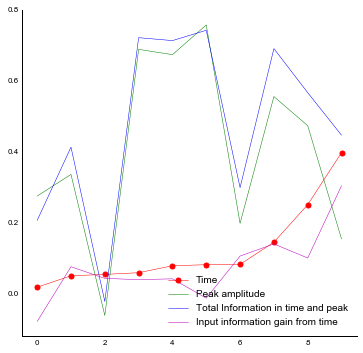

In [12]:
I_te, I_oe, I_ote, I_t_gain = np.array(I_te), np.array(I_oe), np.array(I_ote), np.array(I_t_gain)
fig, ax = plt.subplots()
indices = np.argsort(I_te)
ax.plot(I_te[indices], 'r.-', label="Time")
ax.plot(I_oe[indices], c='g', label="Peak amplitude")
#ax.plot(I_te[indices] + I_oe[indices], 'b--', label="Sum of time and peak amplitude")
ax.plot(I_ote[indices], c='b', label="Total Information in time and peak")
ax.plot(I_t_gain[indices], c='m', label="Input information gain from time")
simpleaxis(ax)
plt.legend()
fig.set_figheight(6)
fig.set_figwidth(6)
plt.savefig('figures/Fig_7_b.png')
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
plt.show()

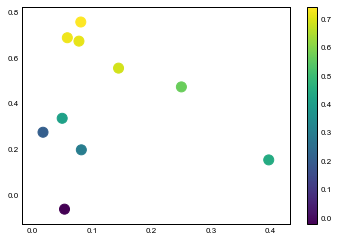

In [13]:
fig, ax = plt.subplots()
cbar = ax.scatter(I_te, I_oe, c= I_ote, cmap=plt.cm.viridis)
# ax.set_xlim(0,0.4)
# ax.set_ylim(0,1)
plt.colorbar(cbar)
plt.show()

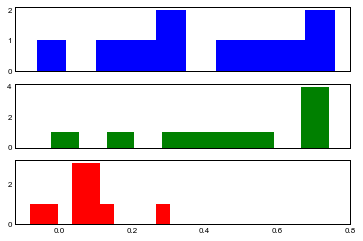

In [14]:
fig, ax = plt.subplots(3,1,sharex=True)
#ax.hist(I_te, color='r', alpha=0.2)
ax[0].hist(I_oe, color='b', alpha=1)
#ax.hist(I_te + I_oe, color='g', alpha=0.2)
ax[1].hist(I_ote, color='g', alpha=1)
ax[2].hist(I_t_gain, color='r', alpha=1)
plt.show()

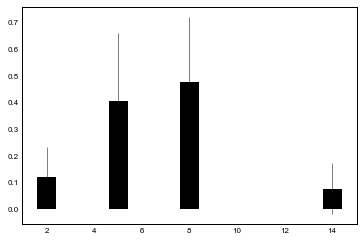

In [15]:
fig1, ax1 = plt.subplots()
ax1.bar(2, np.mean(I_te))
ax1.errorbar(2, np.mean(I_te), yerr= np.std(I_te))

ax1.bar(5, np.mean(I_oe))
ax1.errorbar(5, np.mean(I_oe), yerr= np.std(I_oe))

ax1.bar(8, np.mean(I_ote))
ax1.errorbar(8,np.mean(I_ote), yerr= np.std(I_ote))

#ax1.bar(11, np.mean(I_to))
#ax1.errorbar(11,np.mean(I_to), yerr= np.std(I_to))

ax1.bar(14, np.mean(I_t_gain))
ax1.errorbar(14,np.mean(I_t_gain), yerr= np.std(I_t_gain))
plt.show()

## GABAzine case

### NPEET method

In [209]:
feature = 0 # Area under the curve
minPoints = 0
minIQR = 0.
minSqr = 0
notSqrs = [1]
g_I_te, g_I_oe, g_I_ote, g_I_to, g_I_t_gain = [], [], [], [], []
c_I_te, c_I_oe, c_I_ote, c_I_to, c_I_t_gain = [], [], [], [], []
g_sqr, c_sqr = [], []
#neurons.pop('160920_c1')
#neurons.pop('170222_c2')
tol = 0.1
for index in neurons:
    neuron = neurons[index]
    if "GABAzine" in neuron.experiment:
        print (neuron.date, neuron.index)
#         g_expected, g_observed, g_time, g_sqrArr, g_avgTrace = getPars(neuron, "GABAzine", notSqrs = notSqrs, feature=feature)
#         c_expected, c_observed, c_time, c_sqrArr, c_avgTrace = getPars(neuron, "Control", notSqrs = notSqrs, feature=feature)
        
        g_expected, g_observed, g_time, g_sqrArr, g_avgTrace = getPars_trialwise(neuron, "GABAzine", notSqrs = notSqrs, feature=feature)
        c_expected, c_observed, c_time, c_sqrArr, c_avgTrace = getPars_trialwise(neuron, "Control", notSqrs = notSqrs, feature=feature)
        
        if len(g_expected)>=minPoints and len(c_expected)>=minPoints:
            print (len(g_expected), len(c_expected))
            if ss.iqr(g_expected) >= minIQR and ss.iqr(c_expected) >= minIQR:
                if len(set(c_sqrArr)) >= minSqr and len(set(g_sqrArr)) >= minSqr:
                    
                    g_observed, c_observed = np.array(g_observed), np.array(c_observed)
                    g_expected, c_expected = np.array(g_expected), np.array(c_expected)
                    g_time, c_time = np.array(g_time), np.array(c_time)
                    g_avgTrace, c_avgTrace = np.array(g_avgTrace), np.array(c_avgTrace)
                                        
                    # Removing outliers
                    indices =list(set(np.where(c_time<50)[0]).intersection(np.where(g_time<50)[0]).intersection(np.where(c_time>5)[0]).intersection(np.where(g_time>5)[0]))
                    c_expected = c_expected[indices]
                    c_observed = c_observed[indices]
                    c_time = c_time[indices]
                    g_expected = g_expected[indices]
                    g_observed = g_observed[indices]
                    g_time = g_time[indices]
                    ###### 
                    
                    bins_g = int(min([getNumBins(g_expected), getNumBins(g_observed), getNumBins(g_time)])/1)
                    bins_c = int(min([getNumBins(c_expected), getNumBins(c_observed), getNumBins(c_time)])/1)
#                     bins = min([bins_g, bins_c])
                    
                    if shuffle_test(g_time, g_observed, g_expected, measure='ti') <tol:
                        
                        g_I_ote.append(calc_TI(g_time, g_observed, g_expected ,bins_g))

                        if shuffle_test(g_time, g_expected)< tol:
                            g_I_te.append(calc_MI(g_time, g_expected,bins_g))
#                         else:
#                              g_I_te.append(0)

                        if shuffle_test(g_observed, g_expected)<tol:
                            g_I_oe.append(calc_MI(g_observed, g_expected,bins_g))
#                         else:
#                              g_I_oe.append(0)
                                       
                        if shuffle_test(g_observed, g_time) <tol:
                            g_I_to.append(calc_MI(g_observed, g_time,bins_g))
#                         else:
#                             g_I_to.append(0)
                        
                        if shuffle_test(g_expected,g_time, g_observed, measure='cmi') <tol:
                            g_I_t_gain.append(gain_inf(g_expected,g_time, g_observed, bins_g))
#                         else:
#                             g_I_t_gain.append(0)
                        
                        g_sqr.append(len(set(g_sqrArr)))

                    if shuffle_test(c_time, c_observed, c_expected, measure='ti') < tol:
                        c_I_ote.append(calc_TI(c_time, c_observed, c_expected ,bins_c))
                        
                        if shuffle_test(c_time, c_expected) < tol:
                            c_I_te.append(calc_MI(c_time, c_expected,bins_c))
                        else:
                            c_I_te.append(0)

                        if shuffle_test(c_observed, c_expected) < tol:
                            c_I_oe.append(calc_MI(c_observed, c_expected,bins_c))
                        else:
                            c_I_oe.append(0)
                        
                        if shuffle_test(c_observed, c_time) < tol:
                            c_I_to.append(calc_MI(c_observed, c_time,bins_c))
                        else:
                            c_I_to.append(0)
                        
                        if shuffle_test(c_expected, c_time, c_observed, measure='cmi') < tol:
                            c_I_t_gain.append(gain_inf(c_expected,c_time, c_observed, bins_c))
                        else:
                            c_I_t_gain.append(0)
                        
                        c_sqr.append(len(set(c_sqrArr)))

#                     fig, ax = plt.subplots(1,4)
#                     dotsize =10


#                     ax[0].scatter(c_expected, c_observed,c='k',s=dotsize)
#                     ax[0].scatter(g_expected, g_observed,c='r',s=dotsize)
#                     ax[1].scatter(c_expected, c_time,c='k',s=dotsize)
#                     ax[1].scatter(g_expected, g_time,c='r',s=dotsize)
#                     if (len(g_observed) == len(c_observed)):
                        
#                         ax[2].scatter(g_observed, g_observed-c_observed,c='g',s=dotsize)
#                         ymax = max((ax[2].get_xlim()[1],ax[2].get_ylim()[1]))
#                         ax[2].set_xlim(0,ymax)
#                         ax[2].set_ylim(0,ymax)
#                         excit_gabaz, inhib_derived = [], []
#                         for i,j in zip(g_avgTrace, c_avgTrace):
#                             excit_gabaz.append(np.max(i))
#                             inhib_derived.append(np.max(i-j))
#                         ax[3].scatter( excit_gabaz, inhib_derived, c='m',s=dotsize)
#                         ymax = max((ax[3].get_xlim()[1],ax[3].get_ylim()[1]))
#                         ax[3].set_xlim(0,ymax)
#                         ax[3].set_ylim(0,ymax)
                        
#                     else:
#                         fig.delaxes(ax[2])
#                         fig.delaxes(ax[3])
#                         plt.draw()
#                     ax[0].set_title("{}, {}, {}, {}".format(len(c_expected), len(g_expected), g_sqr[-1], c_sqr[-1]))
#                     fig.set_figwidth(16)
#                     plt.show()
#                     plt.close()

160928 c4
239 72
161117 c1
360 360
170222 c2
286 288
161228 c1
196 288
160830 c1
473 124
161027 c3
71 288
160920 c1
400 351
161013 c1
360 361
160927 c5
90 259
170303 c1
120 334


In [210]:
g_I_te, g_I_oe, g_I_ote, g_I_to, g_I_t_gain, g_sqr = np.array(g_I_te), np.array(g_I_oe), np.array(g_I_ote), np.array(g_I_to), np.array(g_I_t_gain), np.array(g_sqr)
c_I_te, c_I_oe, c_I_ote, c_I_to, c_I_t_gain, c_sqr = np.array(c_I_te), np.array(c_I_oe), np.array(c_I_ote), np.array(c_I_to), np.array(c_I_t_gain), np.array(c_sqr)

In [211]:
len(g_I_oe)

9

In [212]:
g_I_te1, g_I_oe1, g_I_ote1, g_I_to1, g_I_t_gain1, g_sqr1 = g_I_te[g_ind], g_I_oe[g_ind], g_I_ote[g_ind], g_I_to[g_ind], g_I_t_gain[g_ind], g_sqr[g_ind]
c_I_te1, c_I_oe1, c_I_ote1, c_I_to1, c_I_t_gain1, c_sqr1 = c_I_te[c_ind], c_I_oe[c_ind], c_I_ote[c_ind], c_I_to[c_ind], c_I_t_gain[c_ind], c_sqr[c_ind]

In [218]:
c_I_te, c_I_oe, c_I_ote, c_I_to, c_I_t_gain, c_sqr
g_I_te, g_I_oe, g_I_ote, g_I_to, g_I_t_gain, g_sqr

(array([0.        , 0.19579174, 0.        , 0.26915297, 0.11343   ,
        0.09210378, 0.12989045, 0.        , 0.        ]),
 array([0.15595576, 1.45586687, 0.35772389, 1.43570339, 0.4561702 ,
        0.28484879, 1.17948641, 0.57461349, 0.66406511]),
 array([0.18002364, 1.45343573, 0.40726505, 1.52661841, 0.46432726,
        0.38592955, 1.1798343 , 0.44185826, 0.66371386]),
 array([0.        , 0.20174193, 0.0852661 , 0.        , 0.        ,
        0.        , 0.16410771, 0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.09855792, 0.        ,
        0.09586964, 0.        , 0.        , 0.        ]),
 array([3, 5, 4, 3, 3, 4, 5, 2, 4]))

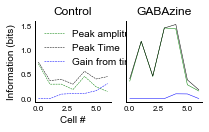

In [214]:
fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
indices = np.argsort(c_I_t_gain)

ax[0].plot(c_I_oe[indices], 'g--', label="Peak amplitude")
ax[0].plot(c_I_ote[indices], 'k--', label="Peak Time")
# ax[1].plot(g_sqr[indices], 'k--', label="sqrs")
# ax[1].plot(c_I_to[indices], c='b', label="Redundancy in peak and time")
ax[0].plot(c_I_t_gain[indices], 'b--', label="Gain from time")
# ax[1].legend()
simpleaxis(ax)
ax[0].set_title("Control")
ax[0].legend()

# ax[0].plot(g_I_te[indices], c='r', label="Time")
ax[1].plot(g_I_oe[indices], c='g', label="Peak amplitude")
ax[1].plot(g_I_ote[indices], c='k', label="Peak and Time")
# ax[0].plot(g_sqr[indices], c='k', label="sqrs")
# ax[0].plot(g_I_to[indices], c='b', label="Redundancy in peak and time")
ax[1].plot(g_I_t_gain[indices], c='b', label="Gain from time")
# ax[0].legend()
# simpleaxis(ax)
# plt.show()
ax[1].set_title("GABAzine")
# fig, ax = plt.subplots()
# ax[1].plot(c_I_te[indices], 'r--', label="Time")


ax[0].set_xlabel("Cell #")
ax[0].set_ylabel("Information (bits)")

fig.set_figheight(1.5)
fig.set_figwidth(3)

dump(fig,file('figures/fig7/7d.pkl','wb'))
plt.show()

### Redundancy between E and T

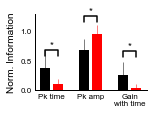

In [215]:
fig1, ax1 = plt.subplots()

ax1.bar(2, np.mean(c_I_te/c_I_ote))
ax1.errorbar(2, np.mean(c_I_te/c_I_ote), yerr= np.std(c_I_te/c_I_ote))

ax1.bar(3, np.mean(g_I_te/g_I_ote), color='r')
ax1.errorbar(3, np.mean(g_I_te/g_I_ote), yerr= np.std(g_I_te/g_I_ote), color='r')
### Significance bars

y, h, col = np.max([np.max(np.mean(g_I_te/g_I_ote)),np.max(np.mean(c_I_te/c_I_ote))])+ 0.2 ,0.1, 'k'
plt.plot([2,2, 3, 3], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((2+3)*.5, y+h, "*", ha='center', va='bottom', color=col)

ax1.bar(5, np.mean(c_I_oe/c_I_ote))
ax1.errorbar(5, np.mean(c_I_oe/c_I_ote), yerr= np.std(c_I_oe/c_I_ote))

ax1.bar(6, np.mean(g_I_oe/g_I_ote), color='r')
ax1.errorbar(6, np.mean(g_I_oe/g_I_ote), yerr= np.std(g_I_oe/g_I_ote), color='r')

y, h, col = np.max([np.max(np.mean(g_I_oe/g_I_ote)),np.max(np.mean(c_I_oe/c_I_ote))])+ 0.2 ,0.1, 'k'
plt.plot([5,5, 6, 6], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((5+6)*.5, y+h, "*", ha='center', va='bottom', color=col)

# ax1.bar(11, np.mean(g_I_ote))
# ax1.errorbar(11,np.mean(g_I_ote), yerr= np.std(g_I_ote))

# ax1.bar(12, np.mean(c_I_ote))
# ax1.errorbar(12,np.mean(c_I_ote), yerr= np.std(c_I_ote))

#ax1.bar(12, np.mean(c_I_to))
#ax1.errorbar(12,np.mean(c_I_to), yerr= np.std(c_I_to))

#ax1.bar(11, np.mean(g_I_to))
#ax1.errorbar(11,np.mean(g_I_to), yerr= np.std(g_I_to))

ax1.bar(8, np.mean(c_I_t_gain/c_I_ote))
ax1.errorbar(8,np.mean(c_I_t_gain/c_I_ote), yerr= np.std(c_I_t_gain/c_I_ote))

ax1.bar(9, np.mean(g_I_t_gain/g_I_ote), color='r')
ax1.errorbar(9,np.mean(g_I_t_gain/g_I_ote), yerr= np.std(g_I_t_gain/g_I_ote), color='r')

y, h, col = np.max([np.max(np.mean(g_I_t_gain/g_I_ote)),np.max(np.mean(c_I_t_gain/c_I_ote))])+ 0.3 ,0.1, 'k'
plt.plot([8,8, 9, 9], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((8+9)*.5, y+h, "*", ha='center', va='bottom', color=col)

ax1.set_ylim(0,1.3)

indices = [2.5, 5.5, 8.5]
ax1.set_xticks(indices)
ax1.set_xticklabels(('Pk time', 'Pk amp', 'Gain\nwith time'))

ax1.set_ylabel("Norm. Information")

simpleaxis(ax1)
fig1.set_figwidth(2)
fig1.set_figheight(1.4)
dump(fig1,file('figures/fig7/7e.pkl','wb'))
plt.show()

In [216]:
print(ss.ranksums(g_I_te/g_I_ote, c_I_te/c_I_ote))
print(ss.ranksums(g_I_to/g_I_ote, c_I_to/c_I_ote))
print(ss.ranksums(g_I_oe/g_I_ote, c_I_oe/c_I_ote))
print(ss.ranksums(g_I_t_gain/g_I_ote, c_I_t_gain/c_I_ote))
print(ss.ranksums(g_I_ote, c_I_ote))

RanksumsResult(statistic=-2.064098883697356, pvalue=0.039008341797342874)
RanksumsResult(statistic=0.4763305116224668, pvalue=0.6338389313837579)
RanksumsResult(statistic=2.593355007722319, pvalue=0.009504460570637122)
RanksumsResult(statistic=-1.9582476588923636, pvalue=0.05020095926358517)
RanksumsResult(statistic=1.1114378604524227, pvalue=0.2663799233424825)


In [170]:
g_I_t_gain/g_I_ote, c_I_t_gain/c_I_ote

(array([-0.00359779,  0.10843325,  0.06122032,  0.24454333,  0.00136958,
        -0.32506275, -0.01157052]),
 array([0.66889561, 0.36698274, 0.05518855, 0.18218559, 0.2379499 ,
        0.39782237, 0.22205184]))

ValueError: x and y must be the same size

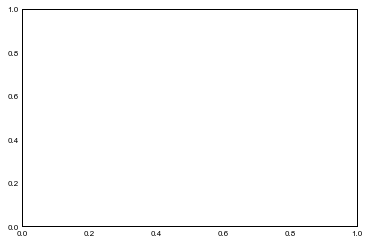

In [25]:
fig, ax = plt.subplots()
ax.scatter(g_I_oe/g_I_ote, c_I_oe/c_I_ote)
ax.set_ylim(ymin=0.)
ax.set_xlim(xmin=0.)
simpleaxis(ax)
plt.show()

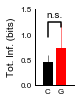

In [219]:
fig1, ax1 = plt.subplots()

ax1.bar(2, np.mean(c_I_ote))
ax1.errorbar(2,np.mean(c_I_ote), yerr= np.std(c_I_ote))

ax1.bar(3, np.mean(g_I_ote), color='r')
ax1.errorbar(3,np.mean(g_I_ote), yerr= np.std(g_I_ote), color='r')

y, h, col = np.max([np.max(np.mean(g_I_ote)),np.max(np.mean(c_I_ote))])+ 0.4 ,0.1, 'k'
plt.plot([2,2, 3, 3], [y-2*h, y+h, y+h, y], lw=1.5, c=col)
plt.text((2+3)*.5, y+1.5*h, "n.s.", ha='center', va='bottom', color=col)
ax1.set_ylim(0,1.5)
ax1.set_xlim(1,4)
indices = [2,3]
ax1.set_xticks(indices)
ax1.set_xticklabels(['C', 'G'])

ax1.set_ylabel("Tot. Inf. (bits)")

simpleaxis(ax1)
fig1.set_figwidth(0.7)
fig1.set_figheight(1.4)
dump(fig1,file('figures/fig7/7f_hist.pkl','wb'))
plt.show()

### Histogram method

In [282]:
feature = 0 # Area under the curve
minPoints = 80
minIQR = 2
minSqr = 0
notSqrs = [1]
g_I_te, g_I_oe, g_I_ote, g_I_to, g_I_t_gain = [], [], [], [], []
c_I_te, c_I_oe, c_I_ote, c_I_to, c_I_t_gain = [], [], [], [], []
g_sqr, c_sqr = [], []
#neurons.pop('160920_c1')
#neurons.pop('170222_c2')
tol = 0.05
for index in neurons:
    neuron = neurons[index]
    if "GABAzine" in neuron.experiment:
        print (neuron.date, neuron.index)
#         g_expected, g_observed, g_time, g_sqrArr, g_avgTrace = getPars(neuron, "GABAzine", notSqrs = notSqrs, feature=feature)
#         c_expected, c_observed, c_time, c_sqrArr, c_avgTrace = getPars(neuron, "Control", notSqrs = notSqrs, feature=feature)
        
        g_expected, g_observed, g_time, g_sqrArr, g_avgTrace = getPars_trialwise(neuron, "GABAzine", notSqrs = notSqrs, feature=feature)
        c_expected, c_observed, c_time, c_sqrArr, c_avgTrace = getPars_trialwise(neuron, "Control", notSqrs = notSqrs, feature=feature)
        
        if len(g_expected)>=minPoints and len(c_expected)>=minPoints:
            print (len(g_expected), len(c_expected))
            if ss.iqr(g_expected) >= minIQR and ss.iqr(c_expected) >= minIQR:
                if len(set(c_sqrArr)) >= minSqr and len(set(g_sqrArr)) >= minSqr:
                    
                    g_observed, c_observed = np.array(g_observed), np.array(c_observed)
                    g_expected, c_expected = np.array(g_expected), np.array(c_expected)
                    g_time, c_time = np.array(g_time), np.array(c_time)
                    g_avgTrace, c_avgTrace = np.array(g_avgTrace), np.array(c_avgTrace)
                                        
                    # Removing outliers
                    indices =list(set(np.where(c_time<50)[0]).intersection(np.where(g_time<50)[0]).intersection(np.where(c_time>5)[0]).intersection(np.where(g_time>5)[0]))
                    c_expected = c_expected[indices]
                    c_observed = c_observed[indices]
                    c_time = c_time[indices]
                    g_expected = g_expected[indices]
                    g_observed = g_observed[indices]
                    g_time = g_time[indices]
                    ###### 
                    
                    bins_g = int(min([getNumBins(g_expected), getNumBins(g_observed), getNumBins(g_time)])/1)
                    bins_c = int(min([getNumBins(c_expected), getNumBins(c_observed), getNumBins(c_time)])/1)
#                     bins = min([bins_g, bins_c])             
                    
                    g_I_ote.append(calc_TI(g_time, g_observed, g_expected ,bins_g))
                    g_I_te.append(calc_MI(g_time, g_expected,bins_g))
                    g_I_oe.append(calc_MI(g_observed, g_expected,bins_g))
                    g_I_to.append(calc_MI(g_observed, g_time,bins_g))
                    g_I_t_gain.append(gain_inf(g_expected,g_time, g_observed, bins_g))
                    g_sqr.append(len(set(g_sqrArr)))

                    c_I_ote.append(calc_TI(c_time, c_observed, c_expected ,bins_c))
                    c_I_te.append(calc_MI(c_time, c_expected,bins_c))
                    c_I_oe.append(calc_MI(c_observed, c_expected,bins_c))
                    c_I_to.append(calc_MI(c_observed, c_time,bins_c))
                    c_I_t_gain.append(gain_inf(c_expected,c_time, c_observed, bins_c))
                    c_sqr.append(len(set(c_sqrArr)))

#                     fig, ax = plt.subplots(1,4)
#                     dotsize =10


#                     ax[0].scatter(c_expected, c_observed,c='k',s=dotsize)
#                     ax[0].scatter(g_expected, g_observed,c='r',s=dotsize)
#                     ax[1].scatter(c_expected, c_time,c='k',s=dotsize)
#                     ax[1].scatter(g_expected, g_time,c='r',s=dotsize)
#                     if (len(g_observed) == len(c_observed)):
                        
#                         ax[2].scatter(g_observed, g_observed-c_observed,c='g',s=dotsize)
#                         ymax = max((ax[2].get_xlim()[1],ax[2].get_ylim()[1]))
#                         ax[2].set_xlim(0,ymax)
#                         ax[2].set_ylim(0,ymax)
#                         excit_gabaz, inhib_derived = [], []
#                         for i,j in zip(g_avgTrace, c_avgTrace):
#                             excit_gabaz.append(np.max(i))
#                             inhib_derived.append(np.max(i-j))
#                         ax[3].scatter( excit_gabaz, inhib_derived, c='m',s=dotsize)
#                         ymax = max((ax[3].get_xlim()[1],ax[3].get_ylim()[1]))
#                         ax[3].set_xlim(0,ymax)
#                         ax[3].set_ylim(0,ymax)
                        
#                     else:
#                         fig.delaxes(ax[2])
#                         fig.delaxes(ax[3])
#                         plt.draw()
#                     ax[0].set_title("{}, {}, {}, {}".format(len(c_expected), len(g_expected), g_sqr[-1], c_sqr[-1]))
#                     fig.set_figwidth(16)
#                     plt.show()
#                     plt.close()

160928 c4
161117 c1
360 360
170222 c2
286 288
161228 c1
196 288
160830 c1
473 124
161027 c3
160920 c1
400 351
161013 c1
360 361
160927 c5
90 259
170303 c1
120 334


In [283]:
g_I_te, g_I_oe, g_I_ote, g_I_to, g_I_t_gain, g_sqr = np.array(g_I_te), np.array(g_I_oe), np.array(g_I_ote), np.array(g_I_to), np.array(g_I_t_gain), np.array(g_sqr)
c_I_te, c_I_oe, c_I_ote, c_I_to, c_I_t_gain, c_sqr = np.array(c_I_te), np.array(c_I_oe), np.array(c_I_ote), np.array(c_I_to), np.array(c_I_t_gain), np.array(c_sqr)

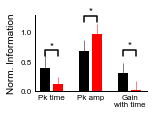

In [284]:
fig1, ax1 = plt.subplots()

ax1.bar(2, np.mean(c_I_te/c_I_ote))
ax1.errorbar(2, np.mean(c_I_te/c_I_ote), yerr= np.std(c_I_te/c_I_ote))

ax1.bar(3, np.mean(g_I_te/g_I_ote), color='r')
ax1.errorbar(3, np.mean(g_I_te/g_I_ote), yerr= np.std(g_I_te/g_I_ote), color='r')
### Significance bars

y, h, col = np.max([np.max(np.mean(g_I_te/g_I_ote)),np.max(np.mean(c_I_te/c_I_ote))])+ 0.2 ,0.1, 'k'
plt.plot([2,2, 3, 3], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((2+3)*.5, y+h, "*", ha='center', va='bottom', color=col)

ax1.bar(5, np.mean(c_I_oe/c_I_ote))
ax1.errorbar(5, np.mean(c_I_oe/c_I_ote), yerr= np.std(c_I_oe/c_I_ote))

ax1.bar(6, np.mean(g_I_oe/g_I_ote), color='r')
ax1.errorbar(6, np.mean(g_I_oe/g_I_ote), yerr= np.std(g_I_oe/g_I_ote), color='r')

y, h, col = np.max([np.max(np.mean(g_I_oe/g_I_ote)),np.max(np.mean(c_I_oe/c_I_ote))])+ 0.2 ,0.1, 'k'
plt.plot([5,5, 6, 6], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((5+6)*.5, y+h, "*", ha='center', va='bottom', color=col)

# ax1.bar(11, np.mean(g_I_ote))
# ax1.errorbar(11,np.mean(g_I_ote), yerr= np.std(g_I_ote))

# ax1.bar(12, np.mean(c_I_ote))
# ax1.errorbar(12,np.mean(c_I_ote), yerr= np.std(c_I_ote))

#ax1.bar(12, np.mean(c_I_to))
#ax1.errorbar(12,np.mean(c_I_to), yerr= np.std(c_I_to))

#ax1.bar(11, np.mean(g_I_to))
#ax1.errorbar(11,np.mean(g_I_to), yerr= np.std(g_I_to))

ax1.bar(8, np.mean(c_I_t_gain/c_I_ote))
ax1.errorbar(8,np.mean(c_I_t_gain/c_I_ote), yerr= np.std(c_I_t_gain/c_I_ote))

ax1.bar(9, np.mean(g_I_t_gain/g_I_ote), color='r')
ax1.errorbar(9,np.mean(g_I_t_gain/g_I_ote), yerr= np.std(g_I_t_gain/g_I_ote), color='r')

y, h, col = np.max([np.max(np.mean(g_I_t_gain/g_I_ote)),np.max(np.mean(c_I_t_gain/c_I_ote))])+ 0.3 ,0.1, 'k'
plt.plot([8,8, 9, 9], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((8+9)*.5, y+h, "*", ha='center', va='bottom', color=col)

ax1.set_ylim(0,1.3)

indices = [2.5, 5.5, 8.5]
ax1.set_xticks(indices)
ax1.set_xticklabels(('Pk time', 'Pk amp', 'Gain\nwith time'))

ax1.set_ylabel("Norm. Information")

simpleaxis(ax1)
fig1.set_figwidth(2)
fig1.set_figheight(1.4)
dump(fig1,file('figures/fig7/7e_hist_method.pkl','wb'))
plt.show()

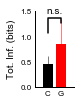

In [285]:
fig1, ax1 = plt.subplots()

ax1.bar(2, np.mean(c_I_ote))
ax1.errorbar(2,np.mean(c_I_ote), yerr= np.std(c_I_ote))

ax1.bar(3, np.mean(g_I_ote), color='r')
ax1.errorbar(3,np.mean(g_I_ote), yerr= np.std(g_I_ote), color='r')

y, h, col = np.max([np.max(np.mean(g_I_ote)),np.max(np.mean(c_I_ote))])+ 0.4 ,0.1, 'k'
plt.plot([2,2, 3, 3], [y-2*h, y+h, y+h, y], lw=1.5, c=col)
plt.text((2+3)*.5, y+1.5*h, "n.s.", ha='center', va='bottom', color=col)
ax1.set_ylim(0,1.5)
ax1.set_xlim(1,4)
indices = [2,3]
ax1.set_xticks(indices)
ax1.set_xticklabels(['C', 'G'])

ax1.set_ylabel("Tot. Inf. (bits)")

simpleaxis(ax1)
fig1.set_figwidth(0.7)
fig1.set_figheight(1.4)
dump(fig1,file('figures/fig7/7f_hist.pkl','wb'))
plt.show()

In [286]:
print(ss.ranksums(g_I_te/g_I_ote, c_I_te/c_I_ote))
print(ss.ranksums(g_I_to/g_I_ote, c_I_to/c_I_ote))
print(ss.ranksums(g_I_oe/g_I_ote, c_I_oe/c_I_ote))
print(ss.ranksums(g_I_t_gain/g_I_ote, c_I_t_gain/c_I_ote))
print(ss.ranksums(g_I_ote, c_I_ote))

RanksumsResult(statistic=-1.9805173514998136, pvalue=0.04764542558436181)
RanksumsResult(statistic=0.19166296949998196, pvalue=0.8480062142193098)
RanksumsResult(statistic=2.3638432904997777, pvalue=0.018086461315687384)
RanksumsResult(statistic=-2.3638432904997777, pvalue=0.018086461315687384)
RanksumsResult(statistic=1.3416407864998738, pvalue=0.17971249487899976)


In [ ]:
print(ss.ranksums(g_I_oe/g_I_ote, c_I_oe/c_I_ote))
print(ss.ranksums(g_I_t_gain/g_I_ote, c_I_t_gain/c_I_ote))

In [195]:
zip(np.array(g_I_te) + np.array(g_I_oe) - np.array(g_I_ote), np.array(c_I_te) + np.array(c_I_oe) - np.array(c_I_ote))

[(-0.020746375929228122, -0.24378850908253025),
 (-0.3918538710885864, -0.5978476096567107),
 (-0.1257812489257617, -0.2017509382791749),
 (-0.24015970702051792, -0.35676806704501196),
 (-0.07494026287844502, -0.37968100616029865),
 (-0.1430378723964516, -0.3055247716470433),
 (-0.29656477105258805, -0.6359536310877942)]

In [196]:
zip(np.array(g_I_te)/g_I_ote , np.array(c_I_te)/c_I_ote )

[(0.18643100786698882, 0.3683941924913172),
 (0.1939665744897002, 0.22511330385993267),
 (0.15484937582306046, 0.21820657573116678),
 (0.20469542182345551, 0.18152889681795806),
 (0.15907776683040645, 0.19427545957566508),
 (0.30519153082732636, 0.32569623845213047),
 (0.2340289986012663, 0.30063600177645994)]

In [197]:
zip(np.array(g_I_oe)/g_I_ote , np.array(c_I_oe)/c_I_ote )

[(0.8010416143305753, 0.3556425890276252),
 (0.4156377297455394, 0.24851792341470688),
 (0.7742283329524754, 0.6362283778291647),
 (0.5165059587985755, 0.469249189089882),
 (0.7891117025093701, 0.39729370792156127),
 (0.5662801140576961, 0.4349116758389324),
 (0.552584350977859, 0.31479311186511877)]

In [ ]:
zip(np.array(g_I_t_gain)/g_I_ote , np.array(c_I_t_gain)/c_I_ote )

In [ ]:
fig, ax = plt.subplots()
indices = np.argsort(c_I_t_gain/c_I_ote)
ax.plot(g_I_to[indices]/g_I_ote[indices], 'r', label="GABAzine MI peak and time")
ax.plot(c_I_to[indices]/c_I_ote[indices], 'k', label="Control MI peak and time")
simpleaxis(ax)
ax.legend()
fig.set_figheight(4)
fig.set_figwidth(8)
plt.show()

In [ ]:
bins = np.linspace(-0.5,0.5,11)
plt.hist((c_I_te - c_I_t_gain)/c_I_ote, bins=bins, color='k',histtype='step')
plt.hist((g_I_te - g_I_t_gain)/g_I_ote, bins=bins, color='r',histtype='step')
plt.vlines(x=0,ymin=0,ymax=6.2,color='g')
plt.ylabel("Interaction Information")
plt.show()

In [ ]:
np.mean(g_I_te/g_I_ote), np.mean(g_I_t_gain/g_I_ote)

In [ ]:
np.mean(c_I_te/c_I_ote), np.mean(c_I_t_gain/c_I_ote)

In [ ]:
c_sqr, g_sqr

# Squares prediction Information Theory

In [53]:
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_with_CS.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [54]:
feature = 0
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n

In [55]:
I_tsq, I_osq, I_otsq = [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            expected = []
            observed = []
            time = []
            sqrArr = []
            for sqr in exp:
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            observed.append(trial.feature[feature])
                            time.append(np.argmax(trial.interestWindow)/20.)
                            sqrArr.append(sqr)
            if len(sqrArr):
                #bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.5)
                bins = max(set(sqrArr)) - 1
                I_tsq.append(calc_MI(time, sqrArr, bins))
                I_osq.append(calc_MI(observed, sqrArr,bins))
                I_otsq.append(calc_TI(time, observed, sqrArr ,bins))

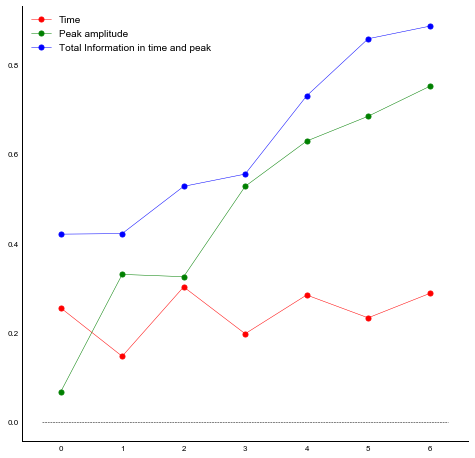

In [56]:
I_tsq, I_osq, I_otsq = np.array(I_tsq), np.array(I_osq), np.array(I_otsq)
fig, ax = plt.subplots()
indices = np.argsort(I_otsq)
ax.plot(I_tsq[indices], 'r.-', label="Time")
ax.plot(I_osq[indices], 'g.-', label="Peak amplitude")
# ax.plot(I_tsq[indices] + I_osq[indices], 'm.--', label="Sum of time and peak amplitude")
ax.plot(I_otsq[indices], 'b.-', label="Total Information in time and peak")
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--')
simpleaxis(ax)
plt.legend()
fig.set_figheight(8)
fig.set_figwidth(8)
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
plt.show()

## GABAzine case

In [57]:
I_tsq, I_osq, I_otsq, n_indices, I_t_gain = [], [], [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    if "GABAzine" in neuron.experiment:
        for expType, exp in neuron:
            ## Control case
            if(expType == "Control"):
                expected = []
                observed = []
                time = []
                sqrArr = []
                for sqr in exp:
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                observed.append(trial.feature[feature])
                                time.append(np.argmax(trial.interestWindow)/20.)
                                sqrArr.append(sqr)
                if len(sqrArr):
                    #bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.5)
                    n_indices.append("{}_{}".format(neuron.date, neuron.index))
                    bins = max(set(sqrArr)) - 1
                    I_tsq.append(calc_MI(time, sqrArr, bins))
                    I_osq.append(calc_MI(observed, sqrArr,bins))
                    I_otsq.append(calc_TI(time, observed, sqrArr ,bins))
                    I_t_gain.append(gain_inf(sqrArr,time, observed,bins))

(0, 1.2)

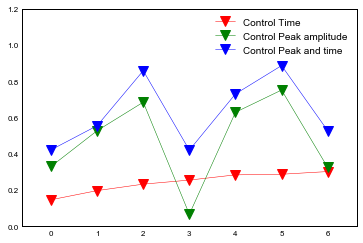

In [58]:
#fig, ax = plt.subplots(2,1,sharex=True)
fig, ax = plt.subplots()
I_tsq, I_osq, I_otsq, I_t_gain = np.array(I_tsq), np.array(I_osq), np.array(I_otsq), np.array(I_t_gain)
indices = np.argsort(I_tsq)
ax.plot(I_tsq[indices], 'rv-', label= "Control " + "Time")
ax.plot(I_osq[indices], 'gv-', label="Control " + "Peak amplitude")
# ax.plot(I_tsq[indices] + I_osq[indices], 'm.--', label="Sum of time and peak amplitude")
ax.plot(I_otsq[indices], 'bv-', label="Control " + "Peak and time")
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--')
ax.legend()
ax.set_ylim(0,1.2)

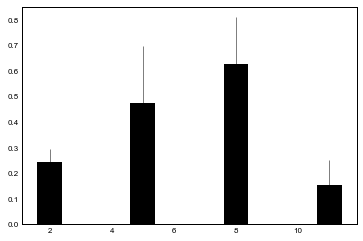

In [59]:
fig1, ax1 = plt.subplots()
ax1.bar(2, np.mean(I_tsq))
ax1.errorbar(2, np.mean(I_tsq), yerr= np.std(I_tsq))

ax1.bar(5, np.mean(I_osq))
ax1.errorbar(5, np.mean(I_osq), yerr= np.std(I_osq))

ax1.bar(8, np.mean(I_otsq))
ax1.errorbar(8,np.mean(I_otsq), yerr= np.std(I_otsq))

ax1.bar(11, np.mean(I_t_gain))
ax1.errorbar(11,np.mean(I_t_gain), yerr= np.std(I_t_gain))

I_t_gain_control = I_t_gain
I_osq_control = I_osq
I_otsq_control = I_otsq

In [60]:
I_tsq, I_osq, I_otsq, n_indices, I_t_gain = [], [], [], [], []
feature = 0 # Area under the curve
for index in neurons:
    neuron = neurons[index]
    for expType, exp in neuron:
        ## Control case
        if(expType == "GABAzine"):
            expected = []
            observed = []
            time = []
            sqrArr = []
            for sqr in exp:
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            observed.append(trial.feature[feature])
                            time.append(np.argmax(trial.interestWindow)/20.)
                            sqrArr.append(sqr)
            if len(sqrArr):
                #bins = int(min([getNumBins(expected) , getNumBins(observed) , getNumBins(time)])/1.5)
                n_indices.append("{}_{}".format(neuron.date, neuron.index))
                bins = max(set(sqrArr)) - 1
                I_tsq.append(calc_MI(time, sqrArr, bins))
                I_osq.append(calc_MI(observed, sqrArr,bins))
                I_otsq.append(calc_TI(time, observed, sqrArr ,bins))
                I_t_gain.append(gain_inf(sqrArr,time, observed,bins))

In [61]:
I_tsq, I_osq, I_otsq, I_t_gain = np.array(I_tsq), np.array(I_osq), np.array(I_otsq), np.array(I_t_gain)
ax.plot(I_tsq[indices], 'ro--', label="GABAzine " + "Time")
ax.plot(I_osq[indices], 'go--', label="GABAzine " + "Peak amplitude")
# ax.plot(I_tsq[indices] + I_osq[indices], 'm.--', label="Sum of time and peak amplitude")
ax.plot(I_otsq[indices], 'bo--', label="GABAzine " + "Peak and time")
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linestyles='--')
ax.legend()
# ax.set_xlim(0,1)
ax.set_ylim(0,1.2)
fig.set_figheight(8)
fig.set_figwidth(8)

In [62]:
ax1.bar(3, np.mean(I_tsq))
ax1.errorbar(3, np.mean(I_tsq), yerr= np.std(I_tsq))

ax1.bar(6, np.mean(I_osq))
ax1.errorbar(6, np.mean(I_osq), yerr= np.std(I_osq))

ax1.bar(9, np.mean(I_otsq))
ax1.errorbar(9,np.mean(I_otsq), yerr= np.std(I_otsq))

ax1.bar(12, np.mean(I_t_gain))
ax1.errorbar(12,np.mean(I_t_gain), yerr= np.std(I_t_gain))
plt.show()

I_t_gain_gaba = I_t_gain
I_osq_gaba = I_osq
I_otsq_gaba = I_otsq

In [63]:
print(ss.ranksums(I_t_gain_gaba, I_t_gain_control))
print(ss.ranksums(I_osq_gaba, I_osq_control))
print(ss.ranksums(I_otsq_gaba, I_otsq_control))

RanksumsResult(statistic=-0.3194382824999699, pvalue=0.7493941849625707)
RanksumsResult(statistic=-0.9583148474999098, pvalue=0.33790401910300505)
RanksumsResult(statistic=-0.9583148474999098, pvalue=0.33790401910300505)
